# League of Legends Project - Elo System

- The purpose of this notebook is to create an elo system for predicting games.
- Rather than simply using the categorical data of the team, player, and champion names, as a feature in a machine learning model, an elo system works chronologically and so doesn't use the results of games that hasn't happened yet to find the impact of a team on the result of the game.
- I will use the teams, the players and the champions in this elo system, each with their own rating.
- The results of the elo system can then be used as a feature in the machine learning models in the LoL_Predictions notebook.

### What is an elo system?

In an elo system, each team has a rating, when 2 teams play each other, the winning team's rating increases and the losing team's decreases.
The size of this increase is determined by the difference in the ratings between the 2 teams.

If the winning team has a rating of 1,600 and the losing team 1,400, the rating change will be smaller than if the winning team had the rating of 1,400 and the losing team a rating of 1,600.  The higher the rating, the better the team is, and so an upset, of a worse team beating

In short, the larger the value of:<br>
losing team rating - winning team rating<br>
the larger the change in rating.

The winning team's rating change is the exact opposite of the losing team's rating change.

Each team's rating is therefore changed after every game they play and until it converges on an "optimal" or "true" rating.

My elo system will calculate the overall team rating as a composite of each player's rating, the team/organisation rating and a rating for each champion selected.

An explanation of the formula to calculate the elo system is located where the formula is, in this notebook.

# Step 1: Clean the Data

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from scipy.optimize import minimize
import matplotlib.pyplot as plt

With convention, I will use a mean elo rating of 1,500 and an elo_width of 400.  This is purely for aesthetic reasons because other publically available elo systems use these metrics.

In [2]:
mean_elo = 1500
elo_width = 400

Reading in the dataframe that was pickled in the LoL_Data_Exploration Notebook

In [3]:
dflol = pd.read_pickle("dflol.pkl")

In [6]:
dflol.head()

,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,1,...,206.0,76.0,-512.0,-18.0,3.0,4.0,0.0,1.0,2.0,2.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,2,...,140.0,-888.0,351.0,-42.0,0.0,5.0,3.0,2.0,1.0,1.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,3,...,225.0,621.0,733.0,8.0,1.0,5.0,1.0,1.0,2.0,0.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,4,...,161.0,3265.0,1950.0,50.0,6.0,2.0,0.0,0.0,0.0,4.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,5,...,28.0,1780.0,2397.0,-19.0,0.0,7.0,0.0,0.0,1.0,3.0


Confirming that the dataset is already in chronological order

In [4]:
dftime = dflol.loc[dflol["participantid"] == 200, ["date", "year"]] # Only selecting 1 row (out of 12) per game
len(dftime["date"][dftime["date"] < dftime["date"].shift()]) # Checking how many games happened before the game above them in the dataset

0

Dropping columns that are not needed for the elo system

In [8]:
dflol = dflol.drop(
    labels=["teamname", "playername", "datacompleteness", "url", "league", "split", "playoffs", "date",
            "game", "patch", "ban1", "ban2", "ban3", "ban4", "ban5", "pick1", "pick2", "pick3", "pick4", "pick5",
            "gamelength", "teamkills", "teamdeaths", "chemtechs", "hextechs", "dragons (type unknown)", "void_grubs",
            "opp_void_grubs", "turretplates", "opp_turretplates", "elementaldrakes", "opp_elementaldrakes",
            "monsterkillsownjungle", "monsterkillsenemyjungle", "participantid", "firstdragon", "dragons",
            "opp_dragons", "infernals", "mountains", "clouds", "oceans", "elders", "opp_elders", "firstherald",
            "heralds", "opp_heralds", "firstbaron", "barons", "opp_barons", "firsttower", "towers", "opp_towers",
            "firstmidtower", "firsttothreetowers", "gspd", "gpr", "team kpm", "ckpm", "kills", "deaths", "assists",
            "doublekills", "triplekills", "quadrakills", "pentakills", "firstblood", "firstbloodkill",
            "firstbloodassist", "firstbloodvictim", "inhibitors", "opp_inhibitors", "damagetochampions", "dpm",
            "damageshare", "damagetakenperminute", "damagemitigatedperminute", "wardsplaced", "wpm", "wardskilled",
            "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm",
            "earnedgoldshare", "goldspent", "total cs", "minionkills", "monsterkills", "cspm", 'goldat10', 'xpat10',
            'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10', 'csdiffat10',
            'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'goldat15',
            'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15',
            'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15', 'goldat20',
            'xpat20', 'csat20', 'opp_goldat20', 'opp_xpat20', 'opp_csat20', 'golddiffat20', 'xpdiffat20', 'csdiffat20',
            'killsat20', 'assistsat20', 'deathsat20', 'opp_killsat20', 'opp_assistsat20', 'opp_deathsat20', 'goldat25',
            'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'golddiffat25', 'xpdiffat25', 'csdiffat25',
            'killsat25', 'assistsat25', 'deathsat25', 'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25'],
    axis=1)

In [9]:
# Columns selected are the year, gameid, side, position, playerid, teamid, champion, and result.
dflol.head(12)

,year,side,position,playerid,teamid,champion,result
gameid,,,,,,,
TRLH3/33,2014,Blue,top,oe:player:e4e943fa882367a96fb2a365de4e28c,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Trundle,1
TRLH3/33,2014,Blue,jng,oe:player:e4cd1e7b68ee6b595a6e4c7cd2c56d8,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Vi,1
TRLH3/33,2014,Blue,mid,oe:player:5d69aabb447fa09188638716fe549b6,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Orianna,1
TRLH3/33,2014,Blue,bot,oe:player:d8362fe0d38ca0e70953ed957deaa00,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Jinx,1
TRLH3/33,2014,Blue,sup,oe:player:5ebcf3b41dc66e5839da4c5f58bd907,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Annie,1
TRLH3/33,2014,Red,top,oe:player:c248a757d55f7ba42f3ffa39f716687,oe:team:3e18c32708da93cf6bdbd1d20b76731,Dr. Mundo,0
TRLH3/33,2014,Red,jng,oe:player:1c7db660fc268b1d2747939129d6101,oe:team:3e18c32708da93cf6bdbd1d20b76731,Shyvana,0
TRLH3/33,2014,Red,mid,oe:player:70f2e5e51d358b04a8485db5a382f1a,oe:team:3e18c32708da93cf6bdbd1d20b76731,LeBlanc,0
TRLH3/33,2014,Red,bot,oe:player:0cd6ba51204139f1e54c05c7c07e154,oe:team:3e18c32708da93cf6bdbd1d20b76731,Lucian,0


Combining the playerid and teamid columns together.  This is not strictly necessary, but it reduces the dimensionality of the dataframe.

In [10]:
dflol["playerid"] = dflol["playerid"].fillna(dflol["teamid"])
dflol = dflol.dropna(subset=["playerid"]).drop("teamid", axis=1)

In [18]:
dflol[dflol['position'] != 'team'].isna().sum()

year        0
side        0
position    0
playerid    0
champion    0
result      0
dtype: int64

There are no missing values in the player rows.

In [17]:
dflol[dflol['position'] == 'team'].isna().sum()

year             0
side             0
position         0
playerid         0
champion    163957
result           0
dtype: int64

The only NaN values in the team rows are in the "champion" column, where teams do not select a champion.

In [19]:
dflol.dtypes

year          uint16
side        category
position    category
playerid      object
champion      object
result         uint8
dtype: object

# Step 2: Data Engineering

In [20]:
# Eliminating the NaN value from the "champion" column by replacing them with "Team".  This allows pd.factorize to be used effectively on the column.
dflol["champion"] = dflol["champion"].fillna("Team")

# Changing the "champion" column to inlude the position of the player as well.  This reflects the different roles of different champions when they are expected to fulfill different roles.
dflol["champion"] = (dflol["position"].astype(str) + "_" + dflol["champion"])

In [21]:
# Factorizing "playerid", and "champion".
dflol["playerid"] = pd.factorize(dflol["playerid"])[0]
dflol["champion"] = pd.factorize(dflol["champion"])[0]

print(f"There are {dflol['playerid'].nunique()} unique players and teams")
print(f"There are {dflol['champion'].nunique()} unique champion position combinations")

There are 11506 unique players and teams
There are 756 unique champion position combinations


### Reshaping the DataFrame
I am reshaping the dataframe to ensure that for each game, there is only 1 column.

In [22]:
# Split the data into winners and losers and adding prefixes.  Because the winners and losers now have column prefixes, I can delete the "result" column.
win_df = dflol[dflol["result"] == 1].drop("result", axis=1).add_prefix("win_", axis=1)

# Because the rows will be combined, in order to prevent duplicate columns, I will delete "result", "side", and "year" from lose_df
lose_df = dflol[dflol["result"] == 0].drop(["result", "side", "year"], axis=1).add_prefix("lose_", axis=1)

In [23]:
# Split the winners and losers into each position.

positions_list1 = list(range(6))
positions_list1[0] = win_df[win_df["win_position"] == "top"]
positions_list1[1] = win_df[win_df["win_position"] == "jng"]
positions_list1[2] = win_df[win_df["win_position"] == "mid"]
positions_list1[3] = win_df[win_df["win_position"] == "bot"]
positions_list1[4] = win_df[win_df["win_position"] == "sup"]
positions_list1[5] = win_df[win_df["win_position"] == "team"]

positions_list2 = list(range(6))
positions_list2[0] = lose_df[lose_df["lose_position"] == "top"]
positions_list2[1] = lose_df[lose_df["lose_position"] == "jng"]
positions_list2[2] = lose_df[lose_df["lose_position"] == "mid"]
positions_list2[3] = lose_df[lose_df["lose_position"] == "bot"]
positions_list2[4] = lose_df[lose_df["lose_position"] == "sup"]
positions_list2[5] = lose_df[lose_df["lose_position"] == "team"]

In [24]:
for i in range(len(positions_list1)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list1[i] = positions_list1[i].drop(["win_position"],
                                               axis=1)

    # Only keep 1 "win_side" and "win_year" column.
    if i > 0:
        positions_list1[i] = positions_list1[i].drop(["win_side", "win_year"],
                                                   axis=1)

    # Choosing the correct prefix.
    if i == 0:
        pos = "top_"
    elif i == 1:
        pos = "jng_"
    elif i == 2:
        pos = "mid_"
    elif i == 3:
        pos = "bot_"
    elif i == 4:
        pos = "sup_"
    else:
        pos = "team_"

    # Adding the new prefixes to the columns.
    new_columns1 = []
    for c in positions_list1[i].columns.to_list():
        c = pos + c
        new_columns1.append(c)
    positions_list1[i].columns = new_columns1

In [25]:
for i in range(len(positions_list2)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list2[i] = positions_list2[i].drop(["lose_position"],
                                                 axis=1)

    # Choosing the correct prefix.
    if i == 0:
        pos = "top_"
    elif i == 1:
        pos = "jng_"
    elif i == 2:
        pos = "mid_"
    elif i == 3:
        pos = "bot_"
    elif i == 4:
        pos = "sup_"
    else:
        pos = "team_"

    # Adding the new prefixes to the columns.
    new_columns2 = []
    for c in positions_list2[i].columns.to_list():
        c = pos + c
        new_columns2.append(c)
    positions_list2[i].columns = new_columns2

In [26]:
# Merging the 12 dataframes into 1 dataframe.
elo_win_df = (reduce(lambda x, y: pd.merge(x,y, on="gameid"),positions_list1)
              .rename({"top_win_side":"side", "top_win_year":"year"}, axis=1))

elo_lose_df = reduce(lambda x, y: pd.merge(x,y, on="gameid"), positions_list2)

elo_df = pd.merge(elo_win_df, elo_lose_df, on="gameid")

In [27]:
elo_df.head()

,year,side,top_win_playerid,top_win_champion,jng_win_playerid,jng_win_champion,mid_win_playerid,mid_win_champion,bot_win_playerid,bot_win_champion,...,jng_lose_playerid,jng_lose_champion,mid_lose_playerid,mid_lose_champion,bot_lose_playerid,bot_lose_champion,sup_lose_playerid,sup_lose_champion,team_lose_playerid,team_lose_champion
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,2014,Blue,0,0,1,1,2,2,3,3,...,6,6,7,7,8,8,9,9,11,10
TRLH3/44,2014,Blue,12,11,13,12,14,13,15,8,...,18,1,19,16,20,17,21,9,23,10
TRLH3/76,2014,Red,0,15,1,1,2,20,3,3,...,18,18,19,16,20,19,21,9,23,10
TRLH3/85,2014,Blue,5,22,6,18,7,23,8,3,...,13,25,14,26,15,8,16,14,22,10
TRLH3/10072,2014,Red,29,15,30,1,31,7,32,27,...,25,18,26,20,27,8,28,21,34,10


Each column corresponds to a single game, with all of the relevant data for that game in just the 1 column (rather than the original 12).

### Preparing the Dataset for the Elo System

In [28]:
# Reorganising the columns of the dataframe to be easier to use with zip()
elo_df = elo_df[["side", "top_win_playerid", "jng_win_playerid", "mid_win_playerid", "bot_win_playerid", "sup_win_playerid", "team_win_playerid",  "top_lose_playerid", "jng_lose_playerid", "mid_lose_playerid", "bot_lose_playerid", "sup_lose_playerid", "team_lose_playerid", "top_win_champion", "jng_win_champion", "mid_win_champion", "bot_win_champion", "sup_win_champion", "top_lose_champion", "jng_lose_champion", "mid_lose_champion", "bot_lose_champion", "sup_lose_champion", "year"]]

In [29]:
# Make the side column into 1s and -1s for the purposes of using it as a home field advantage adjuster.
elo_df["side"] = pd.factorize(elo_df["side"])[0]
elo_df["side"] = ((elo_df["side"] * -2) + 1)
elo_df["side"][:5]

gameid
TRLH3/33       1
TRLH3/44       1
TRLH3/76      -1
TRLH3/85       1
TRLH3/10072   -1
Name: side, dtype: int64

In [33]:
print(f"There are {elo_df.shape[0]} games recorded in elo_df")

There are 81187 games recorded in elo_df


In order to have test dataset that is not trained on games that have not happened yet, I will split the test and train arrays manually, by date, rather than doing so randomly.

In [34]:
train_elo_df = elo_df.iloc[:70000]
test_elo_df = elo_df.iloc[70000:]

# Step 3: Training the Elo System

Elo update formula.  This formula calculates 2 things.

First, it calculates "p" which is the probability that the team that actually won will win.

    p = 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

To do this, it applies the hfa, or home field advantage.  This is a constant that either adds to, or takes away from the winning team's elo rating (only in the calculation) depending on whether the winning team was on Blue side.

    winner_elo + hfa

From the LoL_Data_Exploration notebook, we know that the team on Blue side wins games around 53% of the time, so there is a slight advantage that the elo system will include in its prediction.

After the hfa is accounted for, I find out the difference between the losing team's and winning's team elo.  This is then divided by 400.

    loser_elo - (winner_elo + hfa)) / 400.

This 400, is a fixed constant called the elo_width.  Changing the elo_width does not affect the system's predictions and is primarily an aesthetic feature.  What it technically means is that if a team's rating is 400 larger than the other team, that team's probability of winning is 10x larger than the team with a rating 400 smaller.

This value is then used in 1 / (1+ 10^x) as x.

    1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

This is an exponential decay function.  The value of p will never be above 1 or below 0.  It plateaus around 1 and 0 so that very large differences in teams' ratings (larger than 600) don't have significantly larger probabilities than if the gap was just 400.

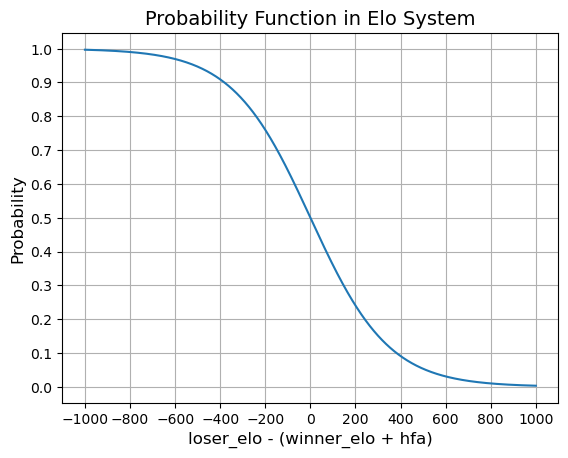

In [46]:
x = np.linspace(-1000,1000,2000)
y = 1. / (1. + np.power(10, x/400))
plt.plot(x, y)

plt.xticks(range(-1000, 1001, 200))
plt.yticks(np.arange(0,1.01,0.1))
plt.grid()

plt.title("Probability Function in Elo System", fontsize=14)
plt.xlabel("loser_elo - (winner_elo + hfa)", fontsize=12)
plt.ylabel("Probability", fontsize=12)

plt.show()

The second part of the update_elo function returns the change in the ratings.

    k * (1. -  p)

 k is a constant that changes depending on the elo system.  A larger k value means that teams' ratings will change more for each match meaning that the system is quick to adjust to changes in a team's relative strength.  A smaller k value means the opposite.  k values are usually between 10 and 100.

I will have to find the optimal value for k, and the optimal value for bsa (Blue Side Advantage), which is used to calculate the hfa.

In [ ]:
def update_elo(winner_elo, loser_elo, k, hfa):

    p = 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

    change = k * (1. - p)

    return (change, p)

### Optimising K and HFA
Within my elo system, there are several other constants to optimise, but first, I will try and find optimal values for k and bsa.

From the LoL_Data_Exploration notebook, I found that the team on Blue side won games 53.2% of the time.

This function is a section of update_elo function and only calculates the probability (p).  I will use it to find a rough value for bsa.

Because I am expecting k and bsa to be well above 1, and the rest of the values I will optimise, to do with adjusting the component ratings before and after games, I am expecting to be around 1, I will find them first to speed up the optimisation process when I use scipy.minimize.

In [47]:
def expected_result(winner_elo, loser_elo, hfa=0):
    return 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400))

In [48]:
# Grid Search
for n in range(0, 50):
    print(n, expected_result(n,0))

0 0.5
1 0.5014391117091528
2 0.502878199574811
3 0.5043172397550598
4 0.5057562084111449
5 0.5071950817090514
6 0.5086338358210827
7 0.5100724469274385
8 0.5115108912177917
9 0.5129491448928637
10 0.5143871841659987
11 0.515824985264735
12 0.5172625244323762
13 0.5186997779295586
14 0.5201367220358165
15 0.5215733330511455
16 0.5230095872975623
17 0.5244454611206615
18 0.525880930891169
19 0.527315973006493
20 0.5287505638922686
21 0.5301846800039021
22 0.5316182978281073
23 0.5330513938844411
24 0.5344839447268315
25 0.5359159269451023
26 0.5373473171664928
27 0.5387780920571715
28 0.5402082283237456
29 0.5416377027147634
30 0.5430664920222119
31 0.544494573083008
32 0.5459219227804837
33 0.5473485180458647
34 0.5487743358597419
35 0.550199353253537
36 0.5516235473109605
37 0.5530468951694625
38 0.554469374021676
39 0.5558909611168531
40 0.5573116337622928
41 0.558731369324761
42 0.5601501452319029
43 0.5615679389736461
44 0.5629847281035958
45 0.5644004902404213
46 0.5658152030692333

We can see that the optimal value is going to be around 22 to 23.

This function is a basic elo system, using only the teams, rather than the teams, players and champions.

I will use it to find a rough optimal value for k.

In [49]:
def elo_train_k(arr):

    bsa = 23 # A rough value for the Blue Side Advantage as found above

    # Converts to NumPy for faster execution speed.
    component_arr = arr.to_numpy(dtype="int16")
    side_arr = arr.to_numpy(dtype="float32")

    # Apply the Blue Side Advantage.  If the winning team is on Red side, their side_arr will be -23, if they're on Blue side, it will be +23.
    side_arr = side_arr[:,0] * bsa

    # Grid Search
    for k in range(10, 100, 5):

        # I am finding an optimal logloss function
        logloss = 0
        # This numpy array will act as a map (instead of a Python dictionary) to store the ratings of the teams.
        player_map = np.full(12000, 1500., dtype="float32")

        # Iterate through each row
        for side, components in zip(side_arr, component_arr):

            hfa, team_win, team_lose = side, components[1], components[2]

            # The "playerid"s stored in the component_arr (originally from elo_df) act as keys for the player_map.
            win_team_elo, lose_team_elo = player_map[team_win], player_map[team_lose]

            # Calculate the change in elo and the probability
            change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

            # Apply the change in elo rating to the player_map
            player_map[team_win] += change
            player_map[team_lose] -= change

            # Calculate the logloss
            logloss += np.log(p)
        # At the end of each iteration print the k value used and the logloss.
        print(k, -logloss / len(component_arr))
    return None

In [50]:
elo_train_k(train_elo_df[["side", "team_win_playerid", "team_lose_playerid"]])

10 0.6554350394734912
15 0.6501899368086747
20 0.6470175789029249
25 0.6451436898459737
30 0.6441773507831957
35 0.6438884211024882
40 0.644128272693288
45 0.6447949618968349
50 0.6458155369784785
55 0.6471361303229535
60 0.648715941554989
65 0.6505234595625413
70 0.652533900526148
75 0.6547274846865979
80 0.6570882211993706
85 0.6596030304487817
90 0.6622610982917856
95 0.6650533963241788


The optimal value seems to be about 35

### Optimising the Elo System

The elo ratings for the players and the champions will need to be adjusted at the end of the year.  So I will have 2 separate constants to adjust them:

    player_year_adj, champ_year_adj

Then, because the winner_elo and loser_elo ratings, that are inputs for the update_elo function, are made of 11 different components (individual elo ratings for each player, the team, and each champion) each of the 11 components will have a multiplier, for how much each component contributes to the total_elo.  These are:

aptop, apjng, apmid, apbot, apsup, apteam<br>
actop, acjng, acmid, acbot, acsup

There are also individual adjusters for how much the components are changed by each game.  (These constants act as individual adjusters to k):

ptopa, pjnga, pmida, pbota, psupa, pteama<br>
ctopa, cjnga, cmida, cbota, csupa

For the variables, in order to keep the names simple, the "a" stands for adjuster, the "p" stands for player and the "c" stands for champion.  The location of the "a" designates whether the adjusting occurs before or after the update_elo function has been used.

These ratings will be a huge variety of values.  k values are generally between 10 and 100 whilst the adjusters will be around 1.  In order to improve the effectiveness of scipy.optimize, I will use 1 dimensional grid-search to predict the values of k and bsa so that they are in the right ballpark before using scipy.optimize.

In [52]:
def elo_system(arr, k, bsa, player_year_adj, champ_year_adj, # The array and the simple adjusters
               aptop, apjng, apmid, apbot, apsup, apteam,
               ptopa, pjnga, pmida, pbota, psupa, pteama,
               actop, acjng, acmid, acbot, acsup,
               ctopa, cjnga, cmida, cbota, csupa):

    # Adjusting multipliers to reduce the range that scipy.minimize needs to evaluate.
    k *= 35
    bsa *= 23
    # To fine tune the parameters of the 24 additional constants, I ran the model to identify which did not fit into the small range I am using for scipy.minimize and created these adjusting multipliers.
    aptop *= 2
    apjng *= 2
    apmid *= 2
    apbot *= 2
    apsup *= 2
    apteam *= 2
    champ_year_adj *= 3
    ctopa *= 3
    cjnga *= 3
    cmida *= 3
    cbota *= 3
    csupa *= 3

    # Storing the "before" multipliers in a np.array (vector).
    multipliers = np.array([aptop, apjng, apmid, apbot, apsup, apteam, actop, acjng, acmid, acbot, acsup])

    # Converting to NumPy for faster execution speed.
    component_arr = arr.to_numpy(dtype="int16")
    side_arr = arr.to_numpy(dtype="float64")

    # Apply the Blue Side Advantage.
    side_arr = side_arr[:,0] * bsa

    # These numpy array will act as maps (instead of a Python dictionary) to store the ratings of the players and the champions.
    player_map = np.full(12000, 1500., dtype="float64")
    champion_map = np.full(1000, 1500., dtype="float64")

    # This will be updated every "New Year".
    current_year = 2014

    # I will try and minimise the logloss function.
    logloss = 0

    # Iterate through every game
    for side, components in zip(side_arr, component_arr):

        # Retrieve the unique ids for the players and champions as well as the year and the side.
        hfa, \
        top_win_playerid, jng_win_playerid, mid_win_playerid, bot_win_playerid, sup_win_playerid, team_win_playerid, \
        top_lose_playerid, jng_lose_playerid, mid_lose_playerid, bot_lose_playerid, sup_lose_playerid, team_lose_playerid, \
        top_win_champion, jng_win_champion, mid_win_champion, bot_win_champion, sup_win_champion, \
        top_lose_champion, jng_lose_champion, mid_lose_champion, bot_lose_champion, sup_lose_champion, \
        year = \
        side, \
        components[1], components[2], components[3], components[4], components[5], components[6], \
        components[7], components[8], components[9], components[10], components[11], components[12], \
        components[13], components[14], components[15], components[16], components[17], \
        components[18], components[19], components[20], components[21], components[22], \
        components[23]

        # Retrieving and storing the 11 composite ratings of the winning team in a np.array (vector).
        win_team_unadjusted = np.array([player_map[top_win_playerid],player_map[jng_win_playerid],
                                        player_map[mid_win_playerid], player_map[bot_win_playerid],
                                        player_map[sup_win_playerid], player_map[team_win_playerid],
                                        champion_map[top_win_champion], champion_map[jng_win_champion],
                                        champion_map[mid_win_champion], champion_map[bot_win_champion],
                                        champion_map[sup_win_champion]])

        # Calculating the winning team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        win_team_elo = (win_team_unadjusted @ multipliers).item()

        # Retrieving and storing the 11 composite ratings of the losing team in a np.array (vector).
        lose_team_unadjusted = np.array([player_map[top_lose_playerid], player_map[jng_lose_playerid],
                                         player_map[mid_lose_playerid], player_map[bot_lose_playerid],
                                         player_map[sup_lose_playerid], player_map[team_lose_playerid],
                                         champion_map[top_lose_champion], champion_map[jng_lose_champion],
                                         champion_map[mid_lose_champion], champion_map[bot_lose_champion],
                                         champion_map[sup_lose_champion]])

        # Calculating the losing team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        lose_team_elo = (lose_team_unadjusted @ multipliers).item()

        # Calculate the change in elo and the probability.
        change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

        # Splitting the probability over the 11 components of each team.
        player_change = change/11

        # Adjusting the ratings for each of the 22 total components using player_change and an adjusting multiplier.
        player_map[top_win_playerid] += player_change * ptopa
        player_map[jng_win_playerid] += player_change * pjnga
        player_map[mid_win_playerid] += player_change * pmida
        player_map[bot_win_playerid] += player_change * pbota
        player_map[sup_win_playerid] += player_change * psupa
        player_map[team_win_playerid] += player_change * pteama

        player_map[top_lose_playerid] -= player_change * ptopa
        player_map[jng_lose_playerid] -= player_change * pjnga
        player_map[mid_lose_playerid] -= player_change * pmida
        player_map[bot_lose_playerid] -= player_change * pbota
        player_map[sup_lose_playerid] -= player_change * psupa
        player_map[team_lose_playerid] -= player_change * pteama

        champion_map[top_win_champion] += player_change * ctopa
        champion_map[jng_win_champion] += player_change * cjnga
        champion_map[mid_win_champion] += player_change * cmida
        champion_map[bot_win_champion] += player_change * cbota
        champion_map[sup_win_champion] += player_change * csupa

        champion_map[top_lose_champion] -= player_change * ctopa
        champion_map[jng_lose_champion] -= player_change * cjnga
        champion_map[mid_lose_champion] -= player_change * cmida
        champion_map[bot_lose_champion] -= player_change * cbota
        champion_map[sup_lose_champion] -= player_change * csupa

        # Checking if the year has ended.
        if current_year < year:

            # Updating the current_year.
            current_year = year

            # Adjusting the player and champion ratings.
            champion_map = (champion_map + (champ_year_adj * 1500))/(champ_year_adj+1)
            player_map = (player_map + (player_year_adj * 1500))/(player_year_adj+1)

        # Using the probability of the winning team winning to calculate the logloss.
        logloss += np.log(p)

    # Printing the logloss so I can keep track of the minimising function.
    print(-logloss / len(component_arr))
    return -logloss / len(component_arr)

In [53]:
elo_system(train_elo_df, 5.57841137e-01, 1.01194766e+00, 3.47445692e-04, 9.35701553e-04,
        2.65025298e+00, 2.35882711e+00, 2.47493312e+00, 1.86229085e+00,
        1.67141062e+00, 1.21735142e+00, 4.92987119e-01, 7.98386747e-01,
        9.04295150e-01, 1.09943810e+00, 1.17425967e+00, 1.38931755e+00,
        1.30876715e-01, 1.72582535e-01, 1.57100100e-01, 8.58475040e-02,
        2.05203021e-01, 1.00701478e+00, 9.75515494e-01, 9.86390921e-01,
        1.09433382e+00, 9.57019802e-01)

0.6288372099925549


0.6288372099925549

In [54]:
# Function to optimise the elo system.
def optimize_elo(params, arr):

    # Defining the 26 parameters of my elo system
    k, bsa, player_year_adj, champ_year_adj, \
    aptop, apjng, apmid, apbot, apsup, apteam, \
    ptopa, pjnga, pmida, pbota, psupa, pteama, \
    actop, acjng, acmid, acbot, acsup, \
    ctopa, cjnga, cmida, cbota, csupa \
    = params

    # Calling the elo_system function
    logloss = elo_system(arr, k, bsa, player_year_adj, champ_year_adj,
                         aptop, apjng, apmid, apbot, apsup, apteam,
                         ptopa, pjnga, pmida, pbota, psupa, pteama,
                         actop, acjng, acmid, acbot, acsup,
                         ctopa, cjnga, cmida, cbota, csupa)

    return logloss

In [55]:
# An initial_guess for each parameter of 1 because I am expecting that the adjusters will be around equal for each component.
initial_guess = [1.] * 26

# Having narrow bounds of between 0 and 3 to decrease the time of the function.
bounds = [(0.0, 3.)] * 26

In [56]:
# I am using the "Powell" method for optimisation because my function (elo_system) is non-derivable and because it has a significant amount (26) constants to be found.
result = minimize(fun=optimize_elo,
                  x0=initial_guess,
                  args=(train_elo_df,),
                  bounds=bounds,
                  method="Powell",
                  options={"maxfev":10000})

0.6568660307265537
0.6617741976679398
0.6960035866919513
0.6502033870232802
0.6562668011245371
0.6492746531067638
0.6490549895875116
0.6490105751535502
0.6490071332774421
0.6490071147647773
0.6490071140600667
0.6490071141119037
0.6490071141240331
0.649092652376924
0.6506849169275081
0.6490855841303996
0.6489954853995116
0.64899548540814
0.6489954853947469
0.6490086265497095
0.6489954853969143
0.6494697152670204
0.6511167435111644
0.6478275007275713
0.6463870510595937
0.645279910133601
0.6445284948683132
0.6440681155722074
0.6438048966807423
0.6436593515112742
0.6435791876596236
0.6435343878368354
0.6435087943584442
0.6434938509847625
0.6434849681905728
0.6434796176739942
0.6434763652218388
0.6434743761243563
0.6434731548908267
0.6434724032347545
0.6434719398764311
0.6434716539608973
0.6434714774296092
0.6434713517666079
0.6434840580601097
0.6435381977483609
0.6434510204996028
0.6434688964658901
0.6434523053641565
0.6434497950740761
0.6434506361806464
0.6434495254599595
0.64344952120632

In [57]:
result.x, result.fun, result.message, result.nfev

(array([0.53403467, 1.02013978, 0.03403804, 0.06360782, 2.72426367,
        2.54966712, 2.63053192, 1.95901974, 1.74168193, 1.25488879,
        0.50089694, 0.7714954 , 0.88687367, 1.08404808, 1.16984449,
        1.42245845, 0.13810847, 0.18921879, 0.15172774, 0.07873365,
        0.1957953 , 0.98824019, 0.96986238, 0.99882058, 1.08391266,
        0.96950485]),
 0.6286664872497395,
 'Optimization terminated successfully.',
 870)

In [32]:
# On my first attempt, which is not shown here, several values were at or nearing 3, and so I added multipliers to those values, namely the before adjuster for players and the after adjusters for champions.
# These are the results of my second attempt, and they give a logloss of 0.62884
# I edited my algorithm to print out the logloss after each iteration so that I could check whether the algorithm converged on an obvious local minima (it is likely the minima would be local anyway.  In this case it didn't, but if it did I would have edited the multipliers to effectively change the starting point, and if that wouldn't work, I would have edited the tolerance.
w_values2 = np.array([5.57841137e-01, 1.01194766e+00, 3.47445692e-04, 9.35701553e-04,
        2.65025298e+00, 2.35882711e+00, 2.47493312e+00, 1.86229085e+00,
        1.67141062e+00, 1.21735142e+00, 4.92987119e-01, 7.98386747e-01,
        9.04295150e-01, 1.09943810e+00, 1.17425967e+00, 1.38931755e+00,
        1.30876715e-01, 1.72582535e-01, 1.57100100e-01, 8.58475040e-02,
        2.05203021e-01, 1.00701478e+00, 9.75515494e-01, 9.86390921e-01,
        1.09433382e+00, 9.57019802e-01])
labels2 = ["k", "bsa", "player_year_adj", "champion_year_adj", "aptop", "apjng", "apmid", "apbot", "apsup", "apteam", "ptopa", "pjnga", "pmida", "pbota", "psupa", "pteama", "actop", "acjng", "acmid", "acbot", "acsup", "ctopa", "cjnga", "cmida", "cbota", "csupa"]
attempt2 = pd.DataFrame(w_values2, labels2)
attempt2.columns = ["w_value"]
attempt2["multiplier"] = [35, 23, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1 ,3, 3, 3, 3, 3]
attempt2["final_value"] = attempt2["w_value"] * attempt2["multiplier"]
attempt2

,w_value,multiplier,final_value
k,0.557841,35,19.524440
bsa,1.011948,23,23.274796
player_year_adj,0.000347,1,0.000347
champion_year_adj,0.000936,1,0.000936
aptop,2.650253,2,5.300506
apjng,2.358827,2,4.717654
apmid,2.474933,2,4.949866
apbot,1.862291,2,3.724582
apsup,1.671411,2,3.342821
apteam,1.217351,2,2.434703


In [33]:
# The values all looked okay to me apart from the player_year_adj and the champion_year_adj that were particularly low, 0.0003 and 0.0009 respectively
# The line of code to check whether the year was changing was:
# if current_year != year:
# The problem with this code is that, whilst the game data is in chronological order (as confirmed at the beginning of the notebook), the year data is not.
(elo_df["year"] != elo_df["year"].shift()).value_counts()
# The True count should be just 11 if the year was in chronological order

year
False    80049
True      1138
Name: count, dtype: int64

In [34]:
# Using datetime, which is in chronological order I can extract the years to get a chronological account of the years.
dftime["datetime_year"] = dftime["date"].dt.year
(dftime["datetime_year"] != dftime["datetime_year"].shift()).value_counts()
# But, because professional LoL covers many league every year and some even cross over between years, it is not necessary to use the exact date.
# So I will simply change the code to
# if current_year < year:
# to ensure that there are only 11 yearly adjustments.

datetime_year
False    82946
True        11
Name: count, dtype: int64

In [35]:
# With the updated function, the logloss was reduced by a fraction to 0.6286664872497395
# The player_year_adj, and champion_year_adj are increased by around 100x
w_values3 = np.array([0.53403467, 1.02013978, 0.03403804, 0.06360782, 2.72426367,
        2.54966712, 2.63053192, 1.95901974, 1.74168193, 1.25488879,
        0.50089694, 0.7714954 , 0.88687367, 1.08404808, 1.16984449,
        1.42245845, 0.13810847, 0.18921879, 0.15172774, 0.07873365,
        0.1957953 , 0.98824019, 0.96986238, 0.99882058, 1.08391266,
        0.96950485])
labels3 = ["k", "bsa", "player_year_adj", "champion_year_adj", "aptop", "apjng", "apmid", "apbot", "apsup", "apteam", "ptopa", "pjnga", "pmida", "pbota", "psupa", "pteama", "actop", "acjng", "acmid", "acbot", "acsup", "ctopa", "cjnga", "cmida", "cbota", "csupa"]
attempt3 = pd.DataFrame(w_values3, labels3)
attempt3.columns = ["w_value"]
attempt3["multiplier"] = [35, 23, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1 ,3, 3, 3, 3, 3]
attempt3["final_value"] = attempt3["w_value"] * attempt3["multiplier"]
attempt3

,w_value,multiplier,final_value
k,0.534035,35,18.691213
bsa,1.020140,23,23.463215
player_year_adj,0.034038,1,0.034038
champion_year_adj,0.063608,1,0.063608
aptop,2.724264,2,5.448527
apjng,2.549667,2,5.099334
apmid,2.630532,2,5.261064
apbot,1.959020,2,3.918039
apsup,1.741682,2,3.483364
apteam,1.254889,2,2.509778


In [69]:
# We can have a closer look at the adjusters and because each value has 2 different adjusters (their impact on the game and their change of rating because of the game), we can multiply these together to find the effect of each one
print("players")
print(attempt3.loc["aptop", "w_value"] * attempt3.loc["ptopa", "w_value"])
print(attempt3.loc["apjng", "w_value"] * attempt3.loc["pjnga", "w_value"])
print(attempt3.loc["apmid", "w_value"] * attempt3.loc["pmida", "w_value"])
print(attempt3.loc["apbot", "w_value"] * attempt3.loc["pbota", "w_value"])
print(attempt3.loc["apsup", "w_value"] * attempt3.loc["psupa", "w_value"])
print(attempt3.loc["apteam", "w_value"] * attempt3.loc["pteama", "w_value"])
print("champions")
print(attempt3.loc["actop", "w_value"] * attempt3.loc["ctopa", "w_value"])
print(attempt3.loc["acjng", "w_value"] * attempt3.loc["cjnga", "w_value"])
print(attempt3.loc["acmid", "w_value"] * attempt3.loc["cmida", "w_value"])
print(attempt3.loc["acbot", "w_value"] * attempt3.loc["cbota", "w_value"])
print(attempt3.loc["acsup", "w_value"] * attempt3.loc["csupa", "w_value"])
# Among payers, top has the least importance by a significant margin with mid having the most importance
# Among champions, bot has the least importance by a significant margin with support and mid having the most importance

players
1.3645753360561697
1.9670564546112481
2.3329494979425465
2.1236715878290995
2.0374970091430655
1.7850271631457755
champions
0.1364843406334093
0.1835161860101202
0.1515487892688892
0.085340400003009
0.189824492957205


In [36]:
# Testing the results
elo_system(test_elo_df,5.57841137e-01, 1.01194766e+00, 3.47445692e-04, 9.35701553e-04,
        2.65025298e+00, 2.35882711e+00, 2.47493312e+00, 1.86229085e+00,
        1.67141062e+00, 1.21735142e+00, 4.92987119e-01, 7.98386747e-01,
        9.04295150e-01, 1.09943810e+00, 1.17425967e+00, 1.38931755e+00,
        1.30876715e-01, 1.72582535e-01, 1.57100100e-01, 8.58475040e-02,
        2.05203021e-01, 1.00701478e+00, 9.75515494e-01, 9.86390921e-01,
        1.09433382e+00, 9.57019802e-01)
# A logloss of 0.63276 is pretty close to the training dataframe and whilst it is higher than the training dataset, we can also note that an elo system is generally less accurate, the fewer matches it has, because it takes time for the system to find an appropriate rating for each team.
# I can incorporate the found elo ratings from train_elo_df in order to find the logloss for the test_elo_df without a dispropotionate amount of time spent on the initial training of the elo ratings.

0.6327592050365145


0.6327592050365145

In [27]:
elo_df

,side,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_playerid,top_lose_playerid,jng_lose_playerid,mid_lose_playerid,...,jng_win_champion,mid_win_champion,bot_win_champion,sup_win_champion,top_lose_champion,jng_lose_champion,mid_lose_champion,bot_lose_champion,sup_lose_champion,year
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,0,1,2,3,4,10,5,6,7,...,1,2,3,4,5,6,7,8,9,2014
TRLH3/44,1,12,13,14,15,16,22,17,18,19,...,12,13,8,14,15,1,16,17,9,2014
TRLH3/76,-1,0,1,2,3,4,10,17,18,19,...,1,20,3,21,11,18,16,19,9,2014
TRLH3/85,1,5,6,7,8,9,11,12,13,14,...,18,23,3,24,11,25,26,8,14,2014
TRLH3/10072,-1,29,30,31,32,33,35,24,25,26,...,1,7,27,4,11,18,20,8,21,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOLTMNT02_194058,-1,9727,7496,2771,2938,2535,2591,2671,3768,10186,...,18,627,331,263,168,205,185,144,21,2025
LOLTMNT02_193442,1,4340,8121,6296,7148,8962,10293,9727,7496,2771,...,1,296,47,635,723,104,494,144,82,2025
LOLTMNT02_193448,1,9727,7496,2771,2938,2535,2591,4340,8121,6296,...,18,749,349,216,77,104,627,381,208,2025


In [39]:
elo_system_test(elo_df)
# This outputs a logloss of just 0.61751

4.567153892758824

In [72]:
# Now that I can confirm that the elo system works, I can record the elo ratings before each match and use it in my logistic regression model to predict games
def elo_system_record(arr):

    k = 19.524439795000003
    bsa = 23.27479618

    arr["predict"] = 0
    arr["win_top_player_elo"] = 0
    arr["win_jng_player_elo"] = 0
    arr["win_mid_player_elo"] = 0
    arr["win_bot_player_elo"] = 0
    arr["win_sup_player_elo"] = 0
    arr["win_team_elo"] = 0

    arr["win_top_champ_elo"] = 0
    arr["win_jng_champ_elo"] = 0
    arr["win_mid_champ_elo"] = 0
    arr["win_bot_champ_elo"] = 0
    arr["win_sup_champ_elo"] = 0

    arr["win_total_elo"] = 0

    arr["lose_top_player_elo"] = 0
    arr["lose_jng_player_elo"] = 0
    arr["lose_mid_player_elo"] = 0
    arr["lose_bot_player_elo"] = 0
    arr["lose_sup_player_elo"] = 0
    arr["lose_team_elo"] = 0

    arr["lose_top_champ_elo"] = 0
    arr["lose_jng_champ_elo"] = 0
    arr["lose_mid_champ_elo"] = 0
    arr["lose_bot_champ_elo"] = 0
    arr["lose_sup_champ_elo"] = 0

    arr["lose_total_elo"] = 0
    multipliers = np.array([5.30050596, 4.71765422, 4.94986624, 3.7245817, 3.34282124, 2.43470284, 0.130876715, 0.172582535, 0.1571001, 0.085847504, 0.205203021])

    player_map = np.full(12000, 1500., dtype="float64")
    champion_map = np.full(1000, 1500., dtype="float64")
    current_year = 2014
    logloss = 0

    for index, row in arr.iterrows():
        hfa, top_win_playerid, jng_win_playerid, mid_win_playerid, bot_win_playerid, sup_win_playerid, team_win_playerid, top_lose_playerid, jng_lose_playerid, mid_lose_playerid, bot_lose_playerid, sup_lose_playerid, team_lose_playerid, top_win_champion, jng_win_champion, mid_win_champion, bot_win_champion, sup_win_champion, top_lose_champion, jng_lose_champion, mid_lose_champion, bot_lose_champion, sup_lose_champion, year, predict, wtpe, wjpe, wmpe, wbpe, wspe, wte, wtce, wjce, wmce, wbce, wsce, win_total_elo, ltpe, ljpe, lmpe, lbpe, lspe, lte, ltce, ljce, lmce, lbce, lsce, lose_total_elo = row

        top_player_welo = player_map[top_win_playerid]
        jng_player_welo = player_map[jng_win_playerid]
        mid_player_welo = player_map[mid_win_playerid]
        bot_player_welo = player_map[bot_win_playerid]
        sup_player_welo = player_map[sup_win_playerid]
        team_player_welo = player_map[team_win_playerid]

        top_player_lelo = player_map[top_lose_playerid]
        jng_player_lelo = player_map[jng_lose_playerid]
        mid_player_lelo = player_map[mid_lose_playerid]
        bot_player_lelo = player_map[bot_lose_playerid]
        sup_player_lelo = player_map[sup_lose_playerid]
        team_player_lelo = player_map[team_lose_playerid]

        top_champion_welo = champion_map[top_win_champion]
        jng_champion_welo = champion_map[jng_win_champion]
        mid_champion_welo = champion_map[mid_win_champion]
        bot_champion_welo = champion_map[bot_win_champion]
        sup_champion_welo = champion_map[sup_win_champion]

        top_champion_lelo = champion_map[top_lose_champion]
        jng_champion_lelo = champion_map[jng_lose_champion]
        mid_champion_lelo = champion_map[mid_lose_champion]
        bot_champion_lelo = champion_map[bot_lose_champion]
        sup_champion_lelo = champion_map[sup_lose_champion]

        win_team_unadjusted = [top_player_welo, jng_player_welo, mid_player_welo, bot_player_welo, sup_player_welo, team_player_welo, top_champion_welo, jng_champion_welo, mid_champion_welo, bot_champion_welo, sup_champion_welo]

        win_team_elo = (np.array(win_team_unadjusted) @ multipliers).item()

        lose_team_unadjusted = [top_player_lelo, jng_player_lelo, mid_player_lelo, bot_player_lelo, sup_player_lelo, team_player_lelo, top_champion_lelo, jng_champion_lelo, mid_champion_lelo, bot_champion_lelo, sup_champion_lelo]

        lose_team_elo = (np.array(lose_team_unadjusted) @ multipliers).item()

        hfa *= bsa
        if win_team_elo + hfa > lose_team_elo:
            predict += 1
        arr.loc[index, ["predict", "win_top_player_elo", "win_jng_player_elo", "win_mid_player_elo", "win_bot_player_elo", "win_sup_player_elo", "win_team_elo", "win_top_champ_elo", "win_jng_champ_elo", "win_mid_champ_elo", "win_bot_champ_elo", "win_sup_champ_elo", "win_total_elo","lose_top_player_elo", "lose_jng_player_elo", "lose_mid_player_elo", "lose_bot_player_elo", "lose_sup_player_elo", "lose_team_elo", "lose_top_champ_elo", "lose_jng_champ_elo", "lose_mid_champ_elo", "lose_bot_champ_elo", "lose_sup_champ_elo", "lose_total_elo"]] = [predict] + win_team_unadjusted + [win_team_elo] + lose_team_unadjusted + [lose_team_elo]

        change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

        player_change = change/11


        player_map[top_win_playerid] += player_change * 0.492987119
        player_map[jng_win_playerid] += player_change * 0.798386747
        player_map[mid_win_playerid] += player_change * 0.90429515
        player_map[bot_win_playerid] += player_change * 1.0994381
        player_map[sup_win_playerid] += player_change * 1.17425967
        player_map[team_win_playerid] += player_change * 1.38931755

        player_map[top_lose_playerid] -= player_change * 0.492987119
        player_map[jng_lose_playerid] -= player_change * 0.798386747
        player_map[mid_lose_playerid] -= player_change * 0.90429515
        player_map[bot_lose_playerid] -= player_change * 1.0994381
        player_map[sup_lose_playerid] -= player_change * 1.17425967
        player_map[team_lose_playerid] -= player_change * 1.38931755

        champion_map[top_win_champion] += player_change * 3.02104434
        champion_map[jng_win_champion] += player_change * 2.926546482
        champion_map[mid_win_champion] += player_change * 2.959172763
        champion_map[bot_win_champion] += player_change * 3.2830014599999995
        champion_map[sup_win_champion] += player_change * 2.871059406

        champion_map[top_lose_champion] -= player_change * 3.02104434
        champion_map[jng_lose_champion] -= player_change * 2.926546482
        champion_map[mid_lose_champion] -= player_change * 2.959172763
        champion_map[bot_lose_champion] -= player_change * 3.2830014599999995
        champion_map[sup_lose_champion] -= player_change * 2.871059406

        if current_year < year:
            current_year = year
            champion_map = (champion_map + (.000935701553 * 1500))/(1.000935701553)
            player_map = (player_map + (.000347445692 * 1500))/(1.000347445692)


        logloss += np.log(p)
    print(-logloss/len(arr))
    return arr

In [73]:
elo_record_df = elo_system_record(elo_df)

0.6272795513951823


In [74]:
#elo_record_df.to_pickle("elolol.pkl")

In [76]:
elo_record_df["predict"].mean()

0.6461009767573627

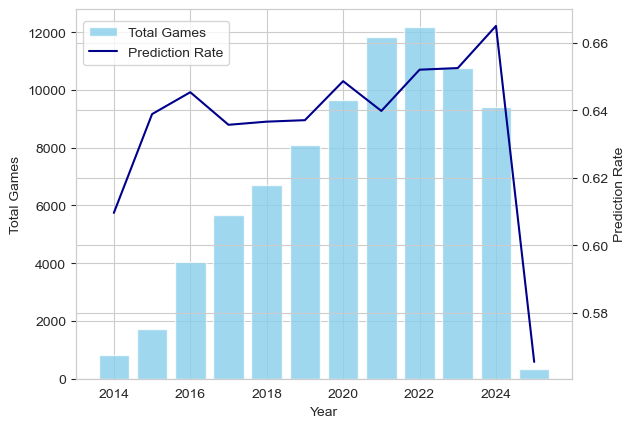

In [34]:
games_each_year = elo_record_df.groupby("year").size()
fig, ax1 = plt.subplots()
ax1.bar(games_each_year.index, games_each_year.values, label="Total Games", color="skyblue", alpha=0.8)
ax1.set_ylabel("Total Games")
ax1.set_xlabel("Year")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(), label="Prediction Rate", color="darkblue")
ax2.set_ylabel("Prediction Rate")

fig.legend(loc='lower center', bbox_to_anchor=(0.25, 0.75), ncol=1)
plt.show()
# We can see a general trend for games getting more accurate in the 5 most recent years compared to the 5 before then.
# We can see a slight correlation between more games and better data.  However, the 2 years with the best predictive effects are 2023 and 2024 which have slightly fewer games.
# However, these missing games are likely to be of lower quality and so may have more volatile results.  It could also be because most of the teams in 2024 already had adjusted data for them.

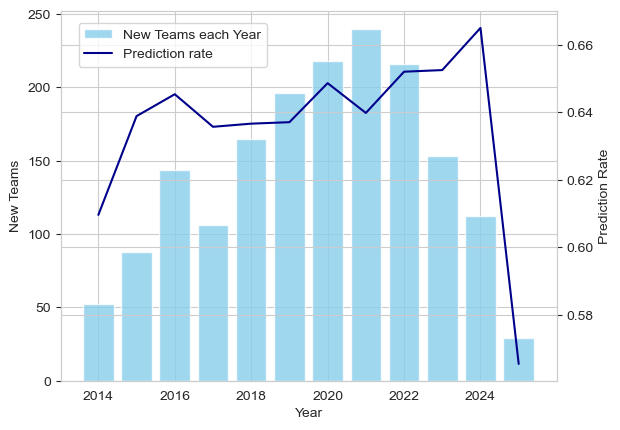

In [35]:
# We can evalute this by looking at the number of new teams per year
new_teams_each_year = elo_record_df.loc[elo_record_df["team_win_playerid"].drop_duplicates().index, "year"].value_counts().sort_index()
fig, ax1 = plt.subplots()
ax1.bar(new_teams_each_year.index, new_teams_each_year.values, label="New Teams each Year", color="skyblue", alpha=0.8)
ax1.set_ylabel("New Teams")
ax1.set_xlabel("Year")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(), label="Prediction rate", color="darkblue")
ax2.set_ylabel("Prediction Rate")

fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1)
plt.show()
# We can see that 2024 and 2023 had fewer new teams per year than the years preceding them.

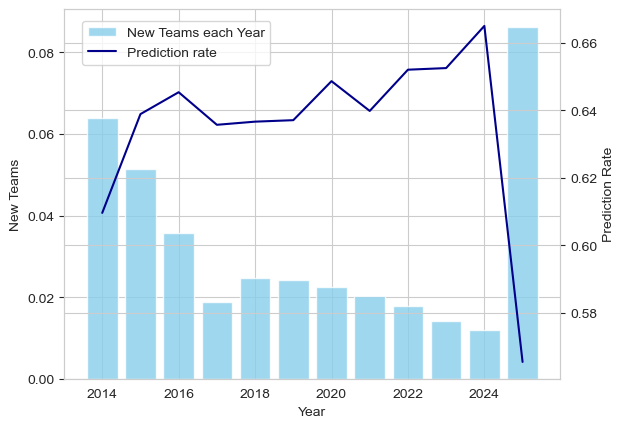

In [36]:
new_teams_per_games_played = new_teams_each_year / games_each_year
fig, ax1 = plt.subplots()
ax1.bar(new_teams_per_games_played.index, new_teams_per_games_played.values, label="New Teams each Year", color="skyblue", alpha=0.8)
ax1.set_ylabel("New Teams")
ax1.set_xlabel("Year")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(), label="Prediction rate", color="darkblue")
ax2.set_ylabel("Prediction Rate")

fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1)
plt.show()
# This seems like a good explanation (at least a closer correlation) for the effectiveness of the elo system.  The system takes time to find the ratings of new teams (and players) and so when there are more new teams with fewer games to adjust their ratings, the accuracy is worse.

In [37]:
pd.DataFrame({"new_teams_per_games_played":new_teams_per_games_played, "prediction_rate":elo_record_df.groupby("year")["predict"].mean()}).corr().iloc[0,1]
# A correlation of -0.90 is very strong and shows that the elo_system works better when it has more data for each team

-0.8999343993578434

In [38]:
elo_record_df

,side,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_playerid,top_lose_playerid,jng_lose_playerid,mid_lose_playerid,...,lose_mid_player_elo,lose_bot_player_elo,lose_sup_player_elo,lose_team_elo,lose_top_champ_elo,lose_jng_champ_elo,lose_mid_champ_elo,lose_bot_champ_elo,lose_sup_champ_elo,lose_total_elo
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,0,1,2,3,4,10,5,6,7,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,37832.613112
TRLH3/44,1,12,13,14,15,16,22,17,18,19,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1502.423506,1500.000000,1500.000000,1497.622444,37832.543486
TRLH3/76,-1,0,1,2,3,4,10,17,18,19,...,1499.250766,1499.089085,1499.027093,1498.848912,1502.503019,1500.000000,1497.548244,1500.000000,1495.243692,37813.137657
TRLH3/85,1,5,6,7,8,9,11,12,13,14,...,1500.749234,1500.910915,1500.972907,1501.151088,1499.934047,1500.000000,1500.000000,1500.001367,1502.378752,37851.534587
TRLH3/10072,-1,29,30,31,32,33,35,24,25,26,...,1500.000000,1500.000000,1500.000000,1500.000000,1497.144695,1500.213487,1502.516359,1496.970148,1502.441431,37832.912468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOLTMNT02_194058,-1,9727,7496,2771,2938,2535,2591,2671,3768,10186,...,1508.800328,1497.075477,1526.155048,1552.722378,1461.707880,1511.191582,1470.302950,1627.574847,1431.727416,38213.907591
LOLTMNT02_193442,1,4340,8121,6296,7148,8962,10293,9727,7496,2771,...,1524.767519,1527.754908,1525.555261,1535.331948,1342.430235,1459.024259,1572.405847,1625.544488,1577.138332,38324.867929
LOLTMNT02_193448,1,9727,7496,2771,2938,2535,2591,4340,8121,6296,...,1520.784530,1520.798333,1499.327469,1502.079069,1734.880440,1455.561853,1649.897431,1572.705640,1524.826633,38219.909274


In [42]:
dflol = pd.read_pickle("dflol.pkl").set_index("gameid")
elo_with_league = elo_record_df.merge(dflol.loc[dflol["participantid"] == 100, "league"], on="gameid")
mean_elo_by_league = elo_with_league.groupby(["league", "year"])[["win_total_elo", "lose_total_elo"]].mean()

In [58]:
(mean_elo_by_league["win_total_elo"] + mean_elo_by_league["lose_total_elo"]).sort_values(ascending=False).head(20)
# We can see that the leagues with the highest average elo are international tournaments where only the best teams from each region qualify (EW, MSI, AC & WLDs).
# We can also see that the highest ratings are more recent and that the elo system, despite having 11 years worth of data has not yet settled and the highest ratings are still rising year over year.
# It is well known that the 2 highest quality domestic leagues are the LCK and LPL, but yet the LCK, lEC and LCS are all present in the top 20, whilst the LPL isn't.
# This could be due to the LCS and LEC importing players from other regions that may already have acquired a high elo rating or due to my system of finding the average elo rating, which finds the average rating for each match played.
# The LCS and LEC may have earlier elimination of its weaker teams and so have its high elo teams play a higher proportion of matches than the high elo LPL teams.


league  year
EWC     2024    76860.720174
MSI     2024    76825.994361
WLDs    2024    76716.916150
MSI     2023    76680.702097
WLDs    2023    76601.070792
MSI     2022    76577.123956
        2021    76514.341387
WLDs    2022    76511.769833
        2021    76492.990130
        2020    76456.854931
AC      2024    76438.504860
MSC     2020    76423.844559
WLDs    2019    76403.828055
LCK     2024    76397.817543
LEC     2024    76386.960689
MSI     2019    76366.962125
LCS     2024    76348.011438
MSI     2018    76346.647882
WLDs    2018    76328.525795
LCK     2023    76317.952291
dtype: float64

In [62]:
# Finally, this is also caused by the elo system being poor at adjusting the ratings between individual leagues.
# Because the default elo ratings for each league are the same, despite some leagues being much higher in quality than others, a player may garner a very high elo rating in a lower league, and whilst this rating will be accurate for their league, if they move to a better league, the system will overestimate how good they are and wrongly predict these games.

# Ideally, there should be a record of each team's (and player's) home league and so there can be a league rating to properly adjust teams and players who move between leagues.  However, the available data does not include this information.
# Therefore, these problems persist in my data.
elo_with_league.groupby(["league"])["predict"].mean().sort_values().head(10)
# We can see this in that the international tournaments AC, EWC & WLDs are all in the bottom 10 leagues for elo predictions

league
NERD      0.452381
EWC       0.473684
AC        0.514286
MSC       0.520000
NASG      0.525641
AOL       0.567568
OCS       0.573446
HC        0.573529
WLDs      0.596787
LVP SL    0.597294
Name: predict, dtype: float64